# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Загрузка данных и библиотек

In [1]:
import pandas as pd 
import numpy as np
from tqdm import notebook
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import lightgbm as lgb
import torch
import transformers
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv', index_col='Unnamed: 0')

In [3]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Библиотеки и данные были загружены.

### Анализ данныз

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


#### Пропуски и дубликаты

In [5]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [6]:
df.duplicated().sum()

0

Пропуски и дубликаты отсутствуют.

#### toxic

Text(0, 0.5, 'количество')

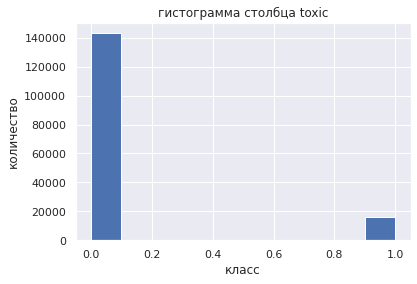

In [7]:
df['toxic'].hist()
plt.title('гистограмма столбца toxic')
plt.xlabel('класс')
plt.ylabel('количество')

В целевом столбце наблюдается значительный(~7:1) дисбаланс. Выбраная метрика F1 и использование стратификации при разделении датасета должно уменьшить влияние дисбаланса на качество классификации.

### Предобработка данных

In [8]:
def clear_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z]', ' ', text)
    cleaned_text = ' '.join(cleaned_text.split()) 
    return cleaned_text

In [9]:
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)

In [10]:
df['text'] = df['text'].apply(clear_text)
df['text'] = df['text'].apply(lemmatize_words)
df['text'] = df['text'].str.lower()

Данные были очищены от символов, лемматизированы и приведены к нижнему регистру.

### Подготовка данных для обучения

In [11]:
X = df['text'] #np.concatenate(embeddings)
y = df['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=123) 

In [12]:
stop_words = set(stopwords.words('english'))

vec = TfidfVectorizer(stop_words=list(stop_words))
vec.fit(X_train)
X_train = vec.transform(X_train)
X_test = vec.transform(X_test)

In [13]:
X_train

<106725x127005 sparse matrix of type '<class 'numpy.float64'>'
	with 2818684 stored elements in Compressed Sparse Row format>

## Обучение

In [28]:
predictions = []

### LogisticRegression

In [29]:
params = {
   'fit_intercept': [True, False], 
    'solver': ['liblinear', 'lbfgs'], 
    'random_state': [123],
    }

model = LogisticRegression(max_iter=1000) 
grid = GridSearchCV(model, params, scoring='f1') 
grid.fit(X_train, y_train) 
grid.best_params_

{'fit_intercept': False, 'random_state': 123, 'solver': 'lbfgs'}

In [30]:
print('F1=', grid.best_score_)
predictions.append(grid.best_score_)

F1= 0.7341824957000052


In [31]:
preds = grid.predict(X_test)
f1_score(y_test, preds)

0.7372340425531915

### LightGBM

In [32]:
params = {
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 31, 63],
    'n_estimators': [500, 700, 900],
    'verbose': [-1],
    'random_state': [123]
}

model = lgb.LGBMClassifier(objective='binary')
grid = GridSearchCV(model, params, scoring='f1') 
grid.fit(X_train, y_train) 
grid.best_params_

{'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 900,
 'num_leaves': 15,
 'random_state': 123,
 'verbose': -1}

In [33]:
print('F1=', grid.best_score_)
predictions.append(grid.best_score_)

F1= 0.7568882155035184


## Выводы

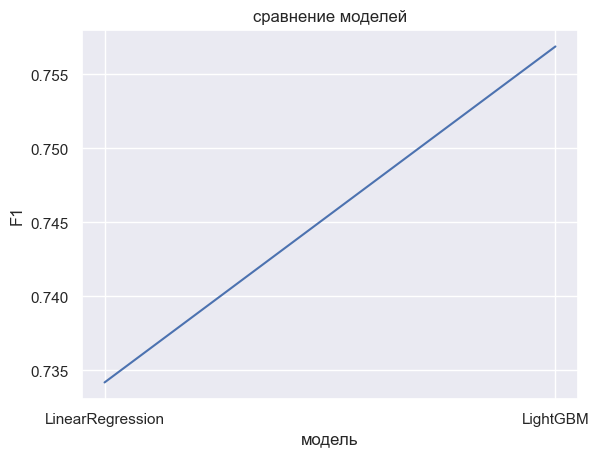

In [40]:
model_list =['LogisticRegression', 'LightGBM']
sns.lineplot(x=model_list, y=predictions)
plt.title('сравнение моделей')
plt.xlabel('модель')
plt.ylabel('F1')
plt.show()

In [42]:
preds = grid.predict(X_test)
print("F1=", f1_score(y_test, preds))

F1= 0.7685025817555937


### Вывод

Тексты комментариев были очищены от посторонних символов, лемматизированы и приведены к нижнему регистру. После разбития на обучающую и тестовую выборку, тексты были векторизированы с помощью TfidfVectorizer.

Для подборки моделей и оптимальных параметров был использован GridSearchCV. Были рассмотрены следующие модели:
* LogisticRegression со значением F1 0.74
* LightGBM со значением F1 0.76

После обучения моделей, наилучшей оказалась модель LightGBM с результатом метрики F1 на тестовой выборке 0.77